In [ ]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
import tensorflow as tf
import numpy as np
import tensorflow_datasets as tfds

In [3]:
dataset_name = "cats_vs_dogs"
data = tfds.load(dataset_name,as_supervised=True, split =('train[:80%]','train[80%:]'))


Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/1 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/23262 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/cats_vs_dogs/incomplete.TTB973_4.0.1/cats_vs_dogs-train.tfrecord*...:   0%…

Dataset cats_vs_dogs downloaded and prepared to /root/tensorflow_datasets/cats_vs_dogs/4.0.1. Subsequent calls will reuse this data.


In [4]:
train_data,test_data = data[0],data[1]
print("Training examples:",len(train_data))
print("Testing examples:",len(test_data))

Training examples: 18610
Testing examples: 4652


In [5]:
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomFlip("horizontal"),
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1)
])

def preprocess(image, label):
    image = tf.image.resize(image, (128, 128))
    image = image / 255.0
    return image, label

train_data = train_data.map(preprocess).map(lambda x, y: (data_augmentation(x), y))
train_data = train_data.shuffle(1000).batch(32).prefetch(tf.data.AUTOTUNE)
test_data = test_data.map(preprocess).batch(32).prefetch(tf.data.AUTOTUNE)


In [6]:
from tensorflow.keras.optimizers import Adam
model = tf.keras.Sequential([
    tf.keras.layers.Rescaling(1./255, input_shape=(128, 128, 3)),
    tf.keras.layers.Conv2D(64, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(128, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(256, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Conv2D(512, (3, 3), activation='relu'),
    tf.keras.layers.BatchNormalization(),
    tf.keras.layers.MaxPooling2D((2, 2)),
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dropout(0.5),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

from tensorflow.keras.optimizers import Adam

optimizer = Adam(learning_rate=0.0001)  # Lower learning rate

model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])

early_stopping = tf.keras.callbacks.EarlyStopping(
    patience=5,
    restore_best_weights=True,
    monitor = "val_accuracy",
    mode = "max"
)


history = model.fit(
    train_data,
    validation_data=test_data,
    epochs=15,  # Try a higher number of epochs
    callbacks=[early_stopping]  # Stop early if there's no improvement
)



Epoch 1/15


/usr/local/lib/python3.10/dist-packages/keras/src/layers/preprocessing/tf_data_layer.py:19: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


582/582 ━━━━━━━━━━━━━━━━━━━━ 119s 181ms/step - accuracy: 0.6287 - loss: 0.8834 - val_accuracy: 0.4920 - val_loss: 3.3041
Epoch 2/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 102s 168ms/step - accuracy: 0.7170 - loss: 0.5565 - val_accuracy: 0.7509 - val_loss: 0.4994
Epoch 3/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 100s 164ms/step - accuracy: 0.7518 - loss: 0.5063 - val_accuracy: 0.7792 - val_loss: 0.4822
Epoch 4/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 100s 166ms/step - accuracy: 0.7811 - loss: 0.4608 - val_accuracy: 0.7992 - val_loss: 0.4350
Epoch 5/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 100s 166ms/step - accuracy: 0.8021 - loss: 0.4283 - val_accuracy: 0.7876 - val_loss: 0.4554
Epoch 6/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 101s 167ms/step - accuracy: 0.8284 - loss: 0.3861 - val_accuracy: 0.8016 - val_loss: 0.4243
Epoch 7/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 99s 164ms/step - accuracy: 0.8404 - loss: 0.3580 - val_accuracy: 0.8040 - val_loss: 0.4554
Epoch 8/15
582/582 ━━━━━━━━━━━━━━━━━━━━ 99s 164ms/step - accuracy: 0.8560 - loss: 0.3360

In [11]:
test_loss, test_accuracy = model.evaluate(test_data)
print(f"Test Accuracy: {test_accuracy * 100:.2f}%")

146/146 ━━━━━━━━━━━━━━━━━━━━ 3s 20ms/step - accuracy: 0.9028 - loss: 0.2386
Test Accuracy: 89.68%


In [7]:
model.save('/kaggle/working/my_model.h5')


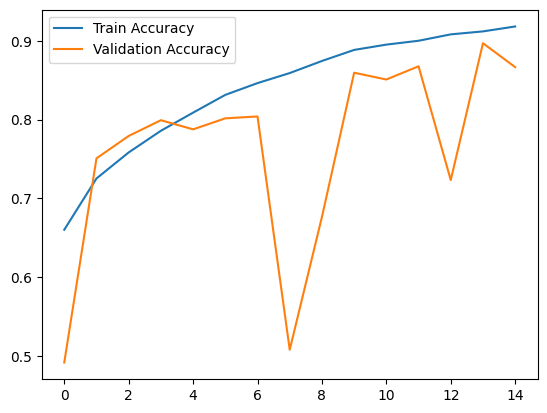

In [8]:
import matplotlib.pyplot as plt
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.show()


**#TESTING THE MODEL**

In [12]:
import os
from tensorflow.keras.preprocessing import image
import numpy as np
from tensorflow.keras.models import load_model

# Load TensorFlow SavedModel format
loaded_model = load_model('/kaggle/working/my_model.h5')

# Directory containing the images
img_dir = '/kaggle/input/dog-jpg/'  # Replace with your directory path

# Iterate through all files in the directory
for img_name in os.listdir(img_dir):
    img_path = os.path.join(img_dir, img_name)

    # Ensure the file is an image (basic check for extensions)
    if img_name.lower().endswith(('.png', '.jpg', '.jpeg')):
        # Load the image in RGB mode
        img = image.load_img(img_path, target_size=(128, 128))

        # Preprocess the image
        img_array = image.img_to_array(img)  # Convert image to array
        img_array = np.expand_dims(img_array, axis=0)  # Add batch dimension
        img_array = img_array / 255.0  # Normalize pixel values

        # Make prediction
        prediction = loaded_model.predict(img_array)
        label = "It's a dog!" if prediction[0] >= 0.5 else "It's a cat!"

        # Print result for the image
        print(f"Image: {img_name} - {label} - Confidence: {prediction[0][0]:.4f}")


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 325ms/step
Image: whitedog.jpg - It's a dog! - Confidence: 0.9993
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 24ms/step
Image: data1.jpg - It's a dog! - Confidence: 0.9470
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: blackcat.jpg - It's a cat! - Confidence: 0.0815
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: pom.jpg - It's a dog! - Confidence: 0.8383
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: neko1.jpg - It's a cat! - Confidence: 0.0153
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: cat.jpg - It's a cat! - Confidence: 0.4028
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: puppy.jpg - It's a dog! - Confidence: 0.9948
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 17ms/step
Image: new data.jpg - It's a dog! - Confidence: 0.9504
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: data.jpg - It's a dog! - Confidence: 1.0000
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 16ms/step
Image: valid.jpg - It's a dog! - Confidence: 1.0000
